 Theunderlying SC was constructed by (i) drawing 400 random points in the unit square;(ii) generating a triangular lattice via Delauney triangulation; (iii) eliminating edgesinside two predefined regions; and (iv) defining all triangles to be faces.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
import scipy as sc
from scipy.spatial import Delaunay
from scipy.spatial.distance import cdist
import random

import pickle

from simplicial_kuramoto import SimplicialComplex
from simplicial_kuramoto.graph_generator import modular_graph
from simplicial_kuramoto.integrators import *
from simplicial_kuramoto import plotting

In [2]:
def get_delauney_holes_multi(n_points, centre_holes,radius,points=[]):


    if not len(points):
        x = np.random.rand(n_points)
        y = np.random.rand(n_points)
        points = np.vstack([x,y]).T

    tri = Delaunay(points)

    edge_list = []
    
    
    idx_inside=np.empty([0], dtype=int)
    for i in range(centre_holes.shape[0]):
        idx_inside=np.hstack([idx_inside,encloses([centre_holes[i]],points,radius)[1]])
    
    for t in tri.simplices:
        
        if t[0] not in idx_inside and t[1] not in idx_inside:
            edge_list.append([t[0], t[1]])
     
        if t[1] not in idx_inside and t[2] not in idx_inside:
            edge_list.append([t[1], t[2]])

        if t[0] not in idx_inside and t[2] not in idx_inside:
            edge_list.append([t[0], t[2]])   


            
    graph = nx.Graph()
    #graph.add_nodes_from(np.arange(len(points)))    
    graph.add_edges_from(edge_list)
    
    Gcc = sorted(nx.connected_components(graph), key=len, reverse=True)
    g = graph.subgraph(Gcc[0])
    
    
    return g, points



def get_delauney(n_points):
    
    x = np.random.rand(n_points)
    y = np.random.rand(n_points)
    points = np.vstack([x,y]).T

    tri = Delaunay(points)
    edge_list = []
    

    for t in tri.simplices:        
        edge_list.append([t[0], t[1]])     
        edge_list.append([t[1], t[2]])
        edge_list.append([t[0], t[2]])   
        
    graph = nx.Graph()
    #graph.add_nodes_from(np.arange(len(points)))    
    graph.add_edges_from(edge_list)
    
    Gcc = sorted(nx.connected_components(graph), key=len, reverse=True)
    g = graph.subgraph(Gcc[0])    
    
    return g, points
    
    
def encloses(centre, points, radius):
    inside_hole = (cdist(centre, points, 'euclidean') <= radius)
    idx_inside = np.where(inside_hole )
    
    return idx_inside




In [3]:
# Plotting the nullspace of L1

def Null_Space_Plot(graph):
    complex_delaunay = SimplicialComplex(graph=graph, no_faces=False)

    B0 = complex_delaunay.node_incidence_matrix
    W0 = complex_delaunay.node_weights_matrix
    B1 = complex_delaunay.edge_incidence_matrix
    W1 = complex_delaunay.edge_weights_matrix
    W2 = complex_delaunay.face_weights_matrix

    Ld = W1.dot(B0.dot(W0.dot(B0.T)))
    Lu = W1.dot(B1.T.dot(W2.dot(B1)))

    L1 = Ld + Lu

    KerL1=sc.linalg.null_space(L1.todense())

    for i in range(KerL1.shape[1]):
        plt.figure()
        nx.draw_networkx_nodes(graph, pos=points, node_size=5)
        nx.draw_networkx_edges(
                graph,
                pos=points,
                edge_color=KerL1[:,i],
                edge_cmap=plt.get_cmap("twilight_shifted"),
                width=5,
                edge_vmin=np.min(KerL1[:,i]),
                edge_vmax=np.max(KerL1[:,i]),
            )
        plt.title('Null space of L1, vector '+str(i))
        plt.show()
        
def extract_spectral_gap(graph):
    # taking the smallest non zero eigenvalue
    
    if type(graph) == nx.Graph:
        complex_delaunay = SimplicialComplex(graph=graph, no_faces=False)
    else:
        complex_delaunay = graph
        

    L1 = complex_delaunay.edge_laplacian
    
    
    u, s, vh = sc.linalg.svd(L1.todense(), full_matrices=True)
    M, N = u.shape[0], vh.shape[1]

    rcond = np.finfo(s.dtype).eps * max(M, N)
    tol = np.amax(s) * rcond

    num = np.sum(s > tol, dtype=int)
    Q = vh[num:,:].T.conj()

    spectral_gap = s[num-1]
    
    return spectral_gap

We created 657 faces
Spectral gap: 0.01749687813376024


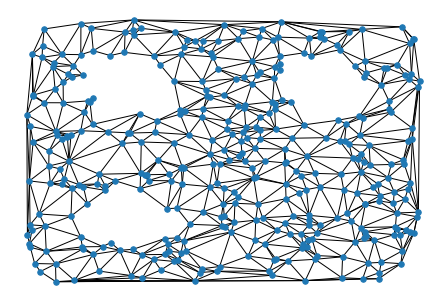

In [4]:
centre_hole_1 = np.array([[0.25,0.25]])
centre_hole_2 = np.array([[0.75,0.75]])
centre_hole_3 = np.array([[0.25,0.75]])

centre_holes=np.concatenate((centre_hole_1,centre_hole_2,centre_hole_3),axis=0)

radius = 0.1

graph, points = get_delauney_holes_multi(400,centre_holes,radius)
pos = dict(enumerate(points))
nx.draw(graph,pos,node_size=30)

print('Spectral gap: {}'.format(extract_spectral_gap(graph)))

We created 723 faces
Spectral gap: 0.015443332236415037


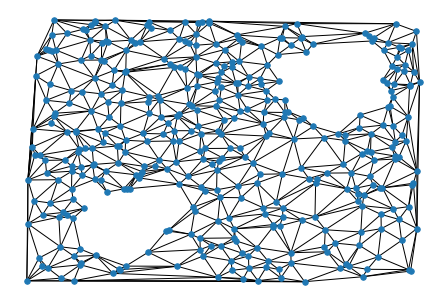

In [5]:
centre_hole_1 = np.array([[0.25,0.25]])
centre_hole_2 = np.array([[0.75,0.75]])

centre_holes=np.concatenate((centre_hole_1,centre_hole_2),axis=0)

radius = 0.1

graph, points = get_delauney_holes_multi(400,centre_holes,radius)
pos = dict(enumerate(points))
nx.draw(graph,pos,node_size=30)

print('Spectral gap: {}'.format(extract_spectral_gap(graph)))

# Single hole size effect

[0.         0.02631579 0.05263158 0.07894737 0.10526316 0.13157895
 0.15789474 0.18421053 0.21052632 0.23684211 0.26315789 0.28947368
 0.31578947 0.34210526 0.36842105 0.39473684 0.42105263 0.44736842
 0.47368421 0.5       ]
We created 794 faces
We created 785 faces
We created 776 faces
We created 768 faces
We created 754 faces
We created 737 faces
We created 713 faces
We created 699 faces
We created 662 faces
We created 637 faces
We created 602 faces
We created 567 faces
We created 522 faces
We created 489 faces
We created 434 faces
We created 379 faces
We created 304 faces
We created 222 faces
We created 167 faces
We created 114 faces


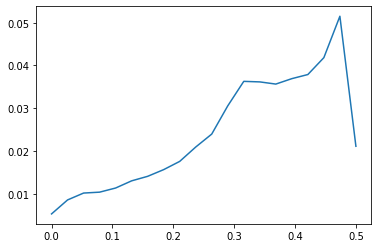

In [113]:
centre_hole = np.array([[0.5,0.5]])

n_points=400
x = np.random.rand(n_points)
y = np.random.rand(n_points)
points = np.vstack([x,y]).T

radii=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45]

radii = np.linspace(0,0.5,20)
print(radii)
s_gaps = []
for radius in radii:
    graph, points = get_delauney_holes_multi(n_points,centre_hole, radius, points)

    s_gaps.append(extract_spectral_gap(graph))

    
plt.plot(radii,s_gaps)

We created 768 faces
We created 768 faces
We created 760 faces
We created 760 faces
We created 730 faces
We created 730 faces
We created 671 faces
We created 671 faces
We created 616 faces
We created 616 faces
We created 557 faces
We created 557 faces
We created 446 faces
We created 446 faces
We created 353 faces
We created 353 faces
We created 251 faces
We created 251 faces


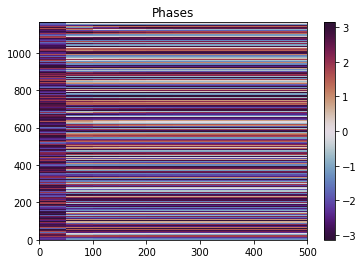

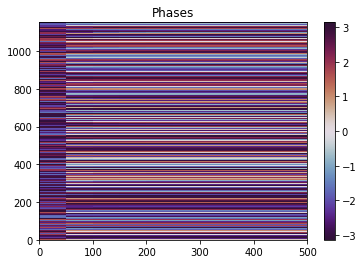

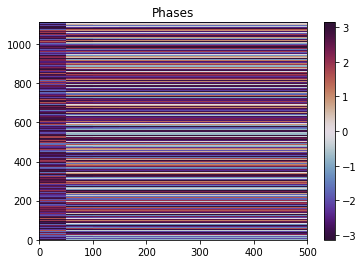

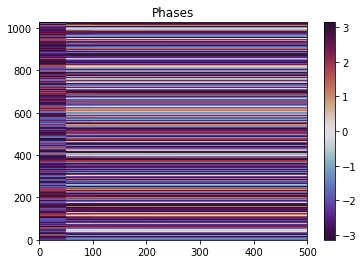

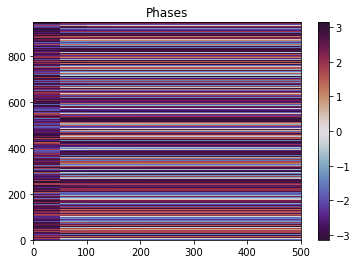

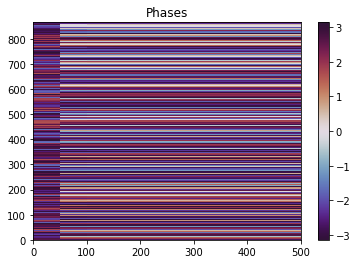

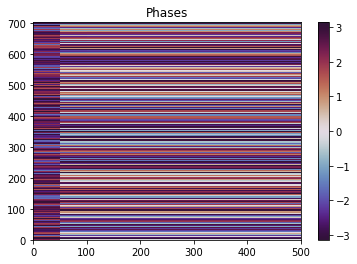

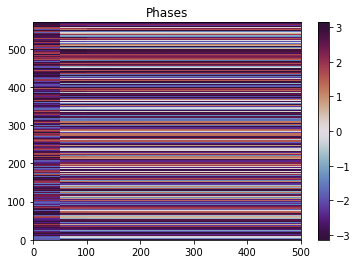

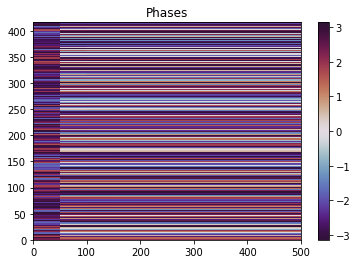

In [56]:
centre_hole = np.array([[0.5,0.5]])

n_points=400
x = np.random.rand(n_points)
y = np.random.rand(n_points)
points = np.vstack([x,y]).T

radii=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45]

s_gaps = []
order_parameters = []
for radius in radii:
    graph, points = get_delauney_holes_multi(n_points,centre_hole, radius, points)

    s_gaps.append(extract_spectral_gap(graph))
  


    np.random.seed(0)
    initial_phase = np.random.uniform(np.pi/2, 3 * np.pi/2, len(graph.edges))

    t_max = 500
    n_t = 10

    complex_delaunay = SimplicialComplex(graph=graph, no_faces=False)

    edge_result = integrate_edge_kuramoto(complex_delaunay, initial_phase, t_max, n_t)
        # plt.savefig("phases_no_faces.png")
    
    
    op = plotting.plot_order_parameter(edge_result.y, return_op=True, plot=False)
    order_parameters.append(op)
    
    

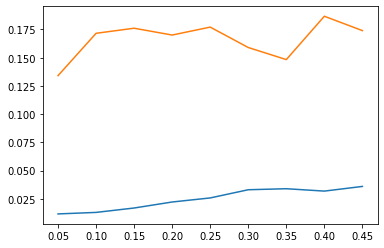

In [63]:
orders = [o[-1] for o in order_parameters]
plt.plot(radii,s_gaps)

plt.plot(radii,orders)

plt.plot(radii,orders)

#  Removing faces but not edges

In [86]:


graph, points = get_delauney(400)
pos = dict(enumerate(points))

print('Spectral gap: {}'.format(extract_spectral_gap(graph)))


all_cliques = nx.enumerate_all_cliques(graph)
faces = [clique for clique in all_cliques if len(clique) == 3]

face_coords = np.array([np.mean(np.vstack([points[node] for node in face]),axis=0).tolist() for face in faces])
face_distance_centre = np.sqrt(((face_coords - 0.5)**2).sum(axis=1))
order_distances = np.argsort(face_distance_centre )[::-1] # reverse order



We created 788 faces
Spectral gap: 0.005246679133277746


In [108]:
s_gaps = []

for i in range(1,len(order_distances)):   
    
    
    faces_idx = order_distances[:-i]
    faces_to_add = [faces[j] for j in faces_idx]
    
    if faces_to_add:
        complex_delaunay = SimplicialComplex(graph=graph, no_faces=False, faces=faces_to_add)
    else: 
        complex_delaunay = SimplicialComplex(graph=graph, no_faces=True)
        
    s_gaps.append(extract_spectral_gap(complex_delaunay))


We created 787 faces
We created 786 faces
We created 785 faces
We created 784 faces
We created 783 faces
We created 782 faces
We created 781 faces
We created 780 faces
We created 779 faces
We created 778 faces
We created 777 faces
We created 776 faces
We created 775 faces
We created 774 faces
We created 773 faces
We created 772 faces
We created 771 faces
We created 770 faces
We created 769 faces
We created 768 faces
We created 767 faces
We created 766 faces
We created 765 faces
We created 764 faces
We created 763 faces
We created 762 faces
We created 761 faces
We created 760 faces
We created 759 faces
We created 758 faces
We created 757 faces
We created 756 faces
We created 755 faces
We created 754 faces
We created 753 faces
We created 752 faces
We created 751 faces
We created 750 faces
We created 749 faces
We created 748 faces
We created 747 faces
We created 746 faces
We created 745 faces
We created 744 faces
We created 743 faces
We created 742 faces
We created 741 faces
We created 74

We created 396 faces
We created 395 faces
We created 394 faces
We created 393 faces
We created 392 faces
We created 391 faces
We created 390 faces
We created 389 faces
We created 388 faces
We created 387 faces
We created 386 faces
We created 385 faces
We created 384 faces
We created 383 faces
We created 382 faces
We created 381 faces
We created 380 faces
We created 379 faces
We created 378 faces
We created 377 faces
We created 376 faces
We created 375 faces
We created 374 faces
We created 373 faces
We created 372 faces
We created 371 faces
We created 370 faces
We created 369 faces
We created 368 faces
We created 367 faces
We created 366 faces
We created 365 faces
We created 364 faces
We created 363 faces
We created 362 faces
We created 361 faces
We created 360 faces
We created 359 faces
We created 358 faces
We created 357 faces
We created 356 faces
We created 355 faces
We created 354 faces
We created 353 faces
We created 352 faces
We created 351 faces
We created 350 faces
We created 34

Text(0, 0.5, 'Spectral Gap')

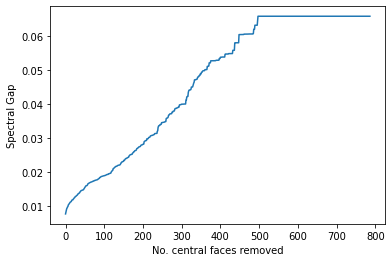

In [110]:
plt.plot(s_gaps)
plt.xlabel("No. central faces removed")
plt.ylabel("Spectral Gap")

# Increasing weight from no-hole to fully filled hole

In [6]:


def get_weighted_delauney(tri,centre_holes,radius,weight_hole):


    # find idx of nodes inside hole
    idx_inside=np.empty([0], dtype=int)
    for i in range(centre_holes.shape[0]):
        idx_inside=np.hstack([idx_inside,encloses([centre_holes[i]],points,radius)[1]])

    # make real edge list
    edge_list = []
    for t in tri.simplices:        
        edge_list.append([t[0], t[1]])     
        edge_list.append([t[1], t[2]])
        edge_list.append([t[0], t[2]])   


    # make edge list of edges to change weight
    edges_to_weight = []
    for t in tri.simplices:        
        if t[0] in idx_inside or t[1] in idx_inside:
            edges_to_weight.append([t[0], t[1]])     
        if t[1] in idx_inside or t[2] in idx_inside:
            edges_to_weight.append([t[1], t[2]])
        if t[0] in idx_inside or t[2] in idx_inside:
            edges_to_weight.append([t[0], t[2]])   


    # create networkx graph
    graph = nx.Graph()
    graph.add_edges_from(edge_list)    
    Gcc = sorted(nx.connected_components(graph), key=len, reverse=True)
    g = graph.subgraph(Gcc[0])   


    # add weights
    for u,v in edge_list:
        g[u][v]["weight"]=1

    for u,v in edges_to_weight:
        g[u][v]["weight"]=weight_hole


    # create simplicial complex fully connected
    complex_delaunay = SimplicialComplex(graph=g,  no_faces=False)


    # plot with edge weights
    plt.figure()
    pos = dict(enumerate(points))
    edges,weights = zip(*nx.get_edge_attributes(g,'weight').items())
    nx.draw_networkx_nodes(graph, pos=points, node_size=5)
    nx.draw_networkx_edges(
                graph,
                pos=points,
                edge_color=weights,
                edge_cmap=plt.get_cmap("YlGn"),
                width=2,
                edge_vmin=0,
                edge_vmax=1,
            )

    # define face weights as product of edge weights
    face_weights_matrix = np.ones(complex_delaunay.n_faces)
    for i,face in enumerate(complex_delaunay.faces): 

        e1 = complex_delaunay.graph.edges[face[0],face[1]]['weight']
        e2 = complex_delaunay.graph.edges[face[0],face[2]]['weight']
        e3 = complex_delaunay.graph.edges[face[1],face[2]]['weight']

        face_w = e1*e2*e3

        face_weights_matrix[i] = face_w

    complex_delaunay.face_weights_matrix = sc.sparse.spdiags(
                    face_weights_matrix, 0, complex_delaunay.n_faces, complex_delaunay.n_faces
                )

    return complex_delaunay

We created 783 faces
Spectral gap: 0.020628683364455013


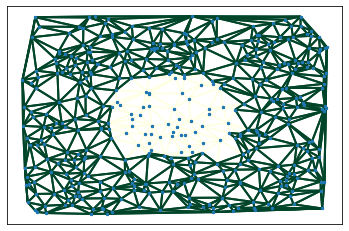

In [7]:
# parameters of delauney
centre_holes = np.array([[0.5,0.5]])
n_points=400
radius = 0.2
hole_weight = 0

x = np.random.rand(n_points)
y = np.random.rand(n_points)
points = np.vstack([x,y]).T
tri = Delaunay(points)

complex_delaunay = get_weighted_delauney(tri,centre_holes,radius,hole_weight)

# this function removes edges and faces with zero weight - otherwise we get infinities 
complex_delaunay.remove_zero_weight_edges_faces()
print('Spectral gap: {}'.format(extract_spectral_gap(complex_delaunay)))

edges,weights = zip(*nx.get_edge_attributes(complex_delaunay.graph,'weight').items())
nx.draw_networkx_nodes(complex_delaunay.graph, pos=points, node_size=5)
nx.draw_networkx_edges(
                complex_delaunay.graph,
                pos=points,
                edge_color=weights,
                edge_cmap=plt.get_cmap("YlGn"),
                width=2,
                edge_vmin=0,
                edge_vmax=1,
            )


1017

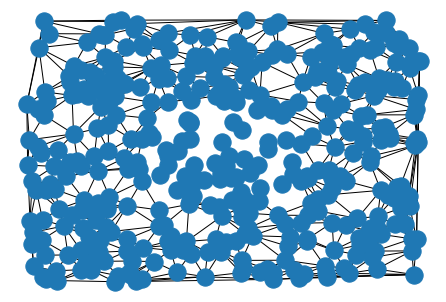

In [8]:
g = complex_delaunay.graph
nx.draw(g,pos = points)
len(g.edges)

1017

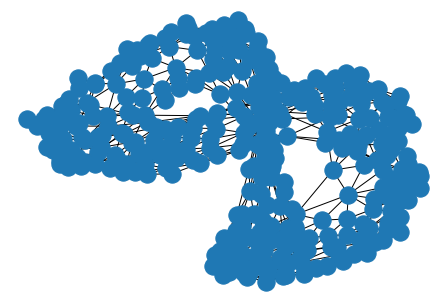

In [9]:
L0 = complex_delaunay.node_laplacian.toarray()
np.fill_diagonal(L0,0)
A = abs(L0)
g = nx.Graph(A)
Gcc = sorted(nx.connected_components(g), key=len, reverse=True)
g = g.subgraph(Gcc[0])   
nx.draw(g,pos = nx.spring_layout(g))
len(g.edges)

We created 788 faces
Spectral gap: 0.03091092570387659
We created 788 faces
Spectral gap: 0.008452808933461916
We created 788 faces
Spectral gap: 0.009886990543282164
We created 788 faces
Spectral gap: 0.009412585950684655
We created 788 faces
Spectral gap: 0.006585981768731589


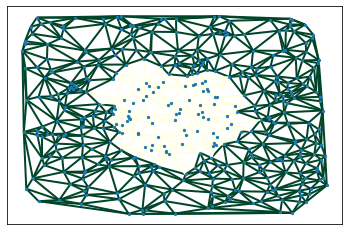

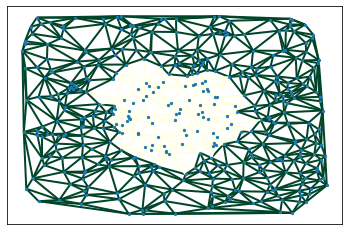

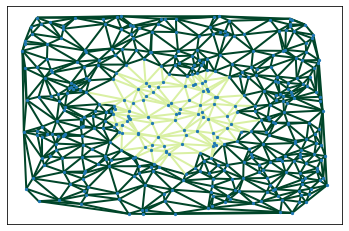

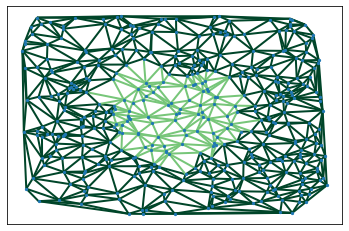

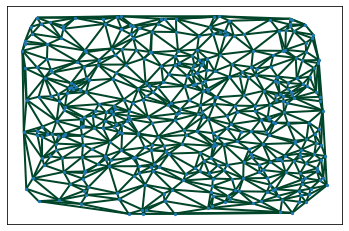

In [10]:

# parameters of delauney
centre_holes = np.array([[0.5,0.5]])
n_points=400
radius = 0.2
hole_weights = [0,0.001,0.25,0.5,1]#np.logspace(-3,0,20)

x = np.random.rand(n_points)
y = np.random.rand(n_points)
points = np.vstack([x,y]).T
tri = Delaunay(points)


for hole_weight in hole_weights:

    complex_delaunay = get_weighted_delauney(tri,centre_holes,radius,hole_weight)
    complex_delaunay.remove_zero_weight_edges_faces()
    print('Spectral gap: {}'.format(extract_spectral_gap(complex_delaunay)))


We created 189 faces
Spectral gap: 0.025482363497811803
We created 189 faces
Spectral gap: 0.02858282729619062
We created 189 faces
Spectral gap: 0.021157847960937934


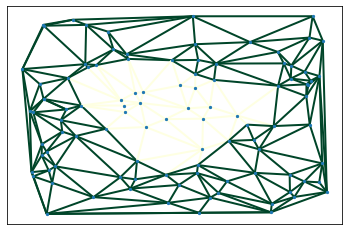

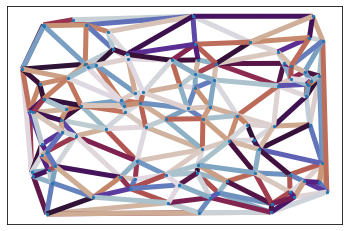

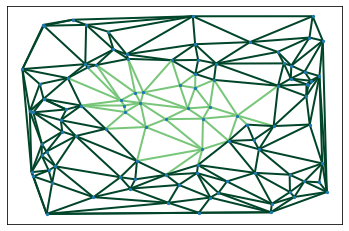

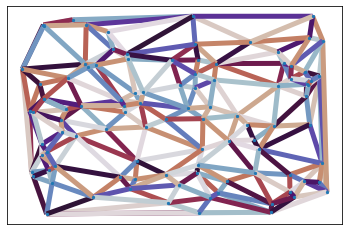

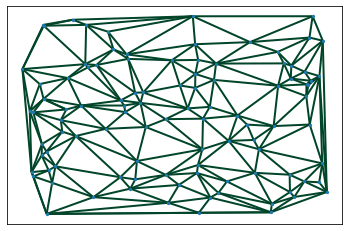

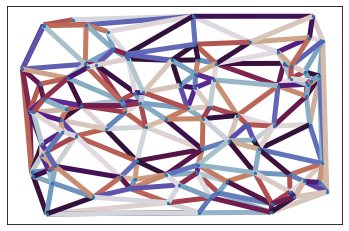

In [12]:
# looping over different edge weights for hole

# parameters of delauney
centre_holes = np.array([[0.5,0.5]])
n_points=100
radius = 0.2
hole_weights = [0.01,0.5,1]#np.logspace(-3,0,20)

x = np.random.rand(n_points)
y = np.random.rand(n_points)
points = np.vstack([x,y]).T
tri = Delaunay(points)


edge_results = []
for i,hole_weight in enumerate(hole_weights):

    complex_delaunay = get_weighted_delauney(tri,centre_holes,radius,hole_weight)
    complex_delaunay.remove_zero_weight_edges_faces()
    print('Spectral gap: {}'.format(extract_spectral_gap(complex_delaunay)))

    np.random.seed(0)
    initial_phase = np.random.uniform(np.pi/2, 3 * np.pi/2, complex_delaunay.edge_weights_matrix.shape[0])
    
    t_max = 500
    n_t = 10
    
    edge_result = integrate_edge_kuramoto(complex_delaunay, initial_phase, t_max, n_t)
    
    edge_results.append(edge_result)
    
    plt.figure()
    nx.draw_networkx_nodes(complex_delaunay.graph, pos=points, node_size=5)
    nx.draw_networkx_edges(
                complex_delaunay.graph,
                pos=points,
                edge_color=edge_results[i].y[:, -1],
                edge_cmap=plt.get_cmap("twilight_shifted"),
                width=5,
                edge_vmin=np.min(edge_results[i].y),
                edge_vmax=np.max(edge_results[i].y),
            )
    
    

We created 189 faces


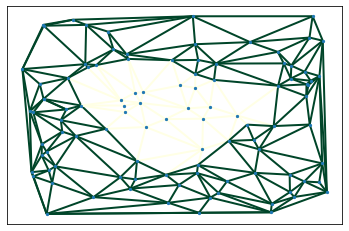

In [14]:
# setting edge weight to zero for hole and taking the phase

complex_delaunay = get_weighted_delauney(tri,centre_holes,radius,0)
idx_edges_removed, idx_faces_removed = complex_delaunay.remove_zero_weight_edges_faces(return_idx=True)


phase_hole = initial_phase[np.where(idx_edges_removed)]

t_max = 500
n_t = 10
    
edge_result = integrate_edge_kuramoto(complex_delaunay, phase_hole, t_max, n_t)



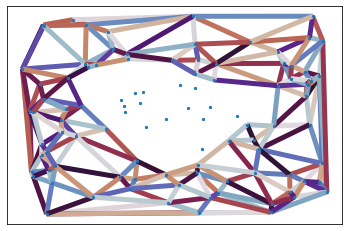

In [15]:

plt.figure()
nx.draw_networkx_nodes(complex_delaunay.graph, pos=points, node_size=5)
nx.draw_networkx_edges(
                complex_delaunay.graph,
                pos=points,
                edge_color=edge_result.y[:, -1],
                edge_cmap=plt.get_cmap("twilight_shifted"),
                width=5,
                edge_vmin=np.min(edge_result.y),
                edge_vmax=np.max(edge_result.y),
            )

In [31]:
# comparison with low edge weight is more similar

from sklearn.metrics.pairwise import cosine_similarity

sim=cosine_similarity(edge_results[0].y[np.where(idx_edges_removed),-1].reshape(-1,1).T,edge_result.y[:,-1].reshape(-1,1).T)
print('Similarity with low edge weight: {}'.format(sim))

Similarity with low edge weight: [[0.94679944]]


In [32]:
sim=cosine_similarity(edge_results[1].y[np.where(idx_edges_removed),-1].reshape(-1,1).T,edge_result.y[:,-1].reshape(-1,1).T)
print('Similarity with mid edge weight: {}'.format(sim))

Similarity with mid edge weight: [[0.94433995]]


In [33]:
sim=cosine_similarity(edge_results[2].y[np.where(idx_edges_removed),-1].reshape(-1,1).T,edge_result.y[:,-1].reshape(-1,1).T)
print('Similarity with high edge weight: {}'.format(sim))

Similarity with high edge weight: [[0.93108966]]
